# Pre

### 读取数据、预处理

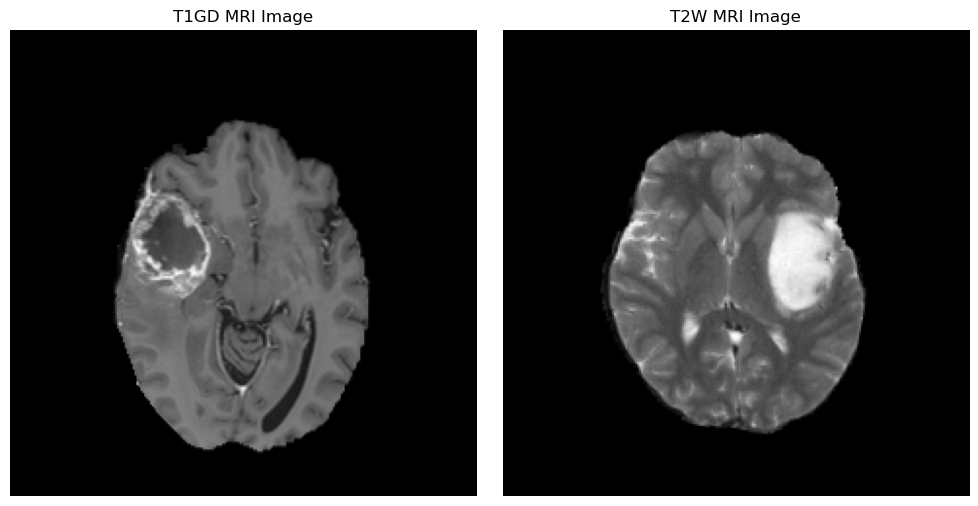

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
t1gd_path = './data/lab5_t1gd.npy'
t2w_path = './data/lab5_t2w.npy'

try:
    t1gd_data = np.load(t1gd_path)
    t2w_data = np.load(t2w_path)

    # 最大最小归一化
    t1gd_data = (t1gd_data - np.min(t1gd_data)) / (np.max(t1gd_data) - np.min(t1gd_data))
    t2w_data = (t2w_data - np.min(t2w_data)) / (np.max(t2w_data) - np.min(t2w_data))

    # 绘制图像
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(t1gd_data, cmap='gray')
    axes[0].set_title('T1GD MRI Image')
    axes[0].axis('off')

    axes[1].imshow(t2w_data, cmap='gray')
    axes[1].set_title('T2W MRI Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("未能找到指定的 .npy 文件，请检查文件路径是否正确。")

# Project 1 Edge Detection

Use the data of lab5, 2 modes of the brain MRI
- Implement the Sobel gradient kernel and get a binary mask with a specified threshold T.
- Segment the lesion (red arrow):
    - 5x5 smooth filter + Sobel filter + threshold T -> edge
    - Remove brain edge
    - Closed operation
    - Connected domain processing

Discuss
- Compare the effects of the 2 modes

### Sobel gradient

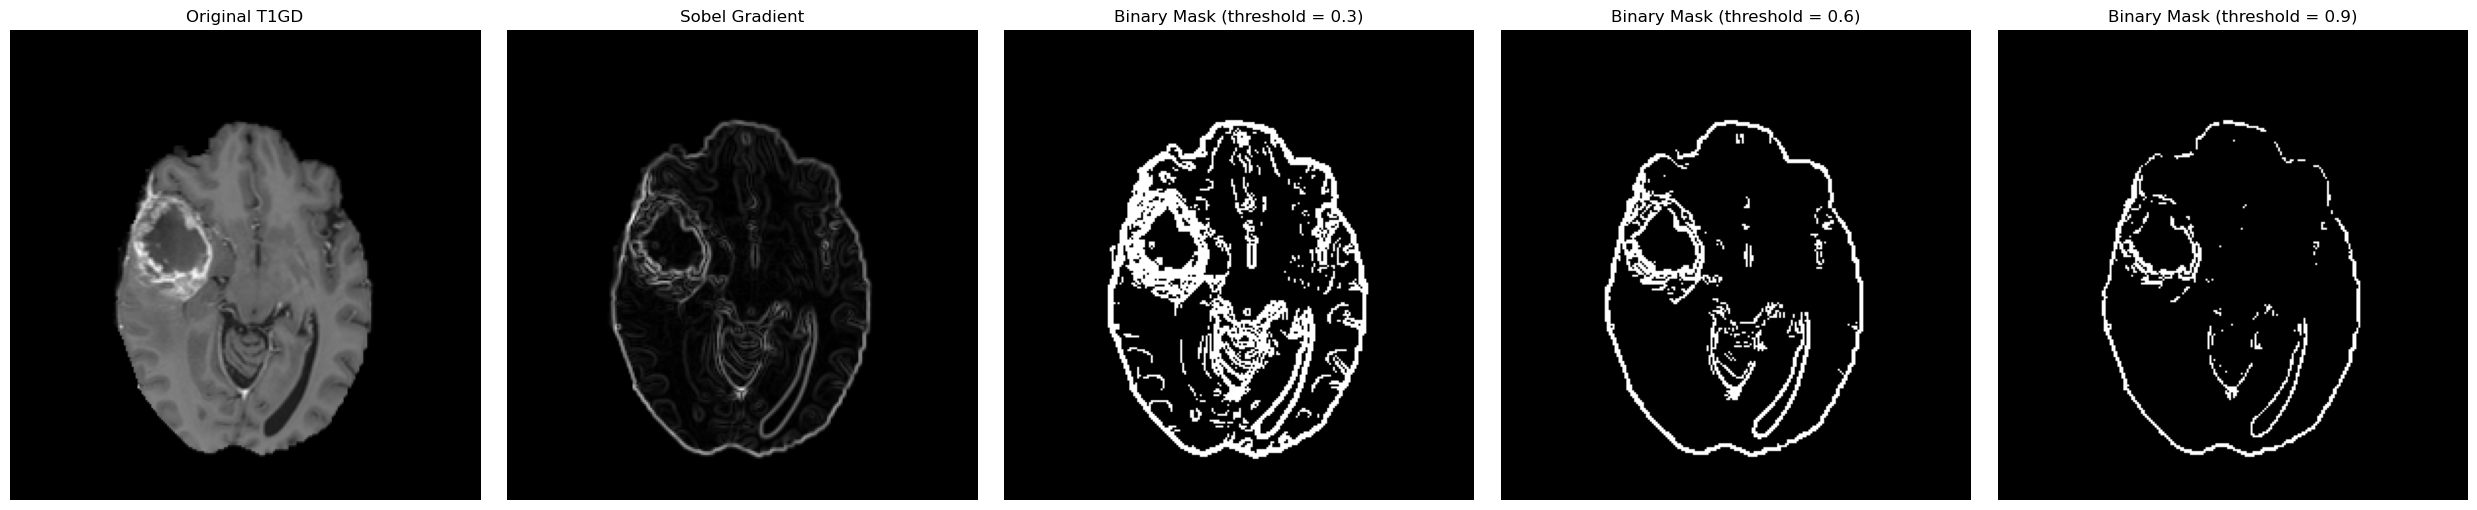

In [88]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# 定义 Sobel 核
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# 计算梯度
gradient_x = ndimage.convolve(t1gd_data.astype(float), sobel_x)
gradient_y = ndimage.convolve(t1gd_data.astype(float), sobel_y)

# 计算梯度幅值
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

# 定义不同的阈值
T_values = [0.3, 0.6, 0.9]

# 创建包含五张子图的画布
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# 绘制原始图
axes[0].imshow(t1gd_data, cmap='gray')
axes[0].set_title('Original T1GD')
axes[0].axis('off')

# 绘制梯度计算结果图
axes[1].imshow(gradient_magnitude, cmap='gray')
axes[1].set_title('Sobel Gradient')
axes[1].axis('off')

# 绘制不同阈值的二值掩码图
for i, T in enumerate(T_values):
    # 生成二值掩码
    binary_mask = (gradient_magnitude > T).astype(np.uint8)
    axes[i + 2].imshow(binary_mask, cmap='gray')
    axes[i + 2].set_title('Binary Mask (threshold = {})'.format(T))
    axes[i + 2].axis('off')

plt.tight_layout()
plt.show()

### Segment the lesion

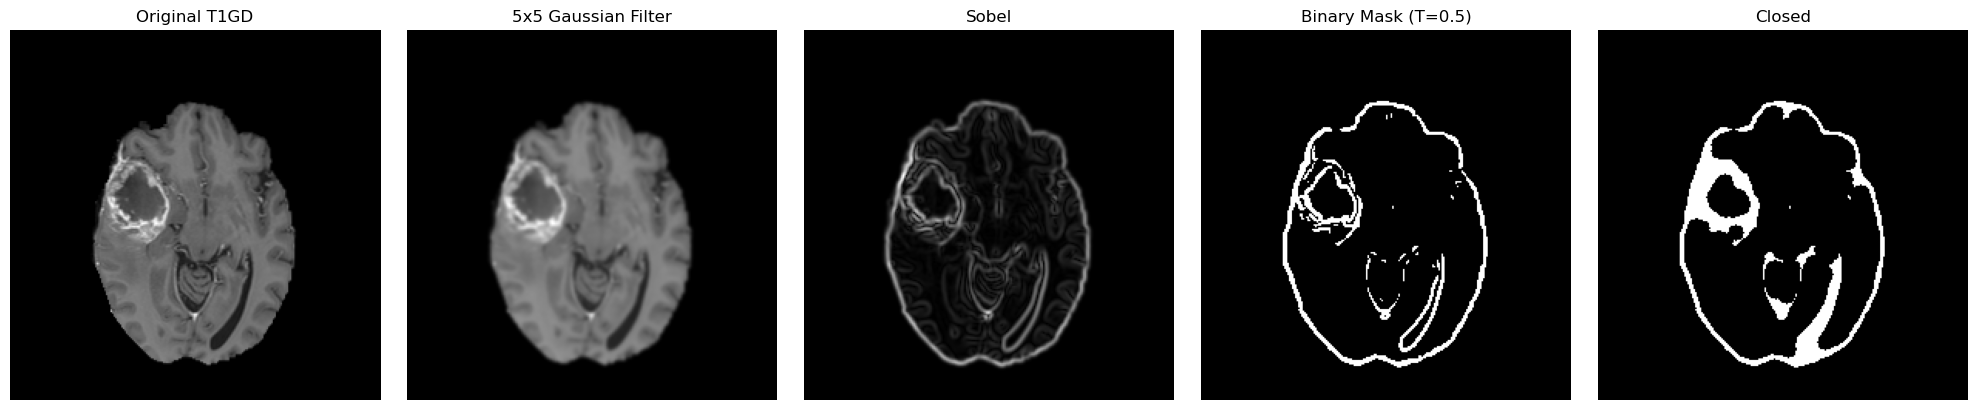

In [89]:
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
import matplotlib.pyplot as plt

# 假设 t1gd_data 已经被正确读取
# t1gd_data = np.load('./data/lab5_t1gd.npy')

# 1. 5x5 高斯滤波
def gaussian_smoothing(image, sigma=1.0):
    return ndimage.gaussian_filter(image, sigma=sigma)

smoothed_image = gaussian_smoothing(t1gd_data)

# 2. Sobel 滤波
def sobel_filter(image):
    sobel_x = ndimage.sobel(image, axis=0)
    sobel_y = ndimage.sobel(image, axis=1)
    return np.sqrt(sobel_x**2 + sobel_y**2)

sobel_gradient = sobel_filter(smoothed_image)

# 3. 取阈值 T 生成 binary mask
T = 0.5
binary_mask = np.where(sobel_gradient > T, 1, 0).astype(np.uint8)

# 5. 闭运算
selem = morphology.disk(5)
closed_mask = morphology.binary_closing(binary_mask, selem)

# 6. 连通域处理
labeled_mask = measure.label(closed_mask)
props = measure.regionprops(labeled_mask)

# 绘制大图
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

plot_titles = ['Original T1GD', '5x5 Gaussian Filter', 'Sobel', f'Binary Mask (T={T})', 'Closed']
plot_images = [t1gd_data, smoothed_image, sobel_gradient, binary_mask, closed_mask]

for ax, img, title in zip(axes, plot_images, plot_titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

### T1GD-Lesion Segmentation

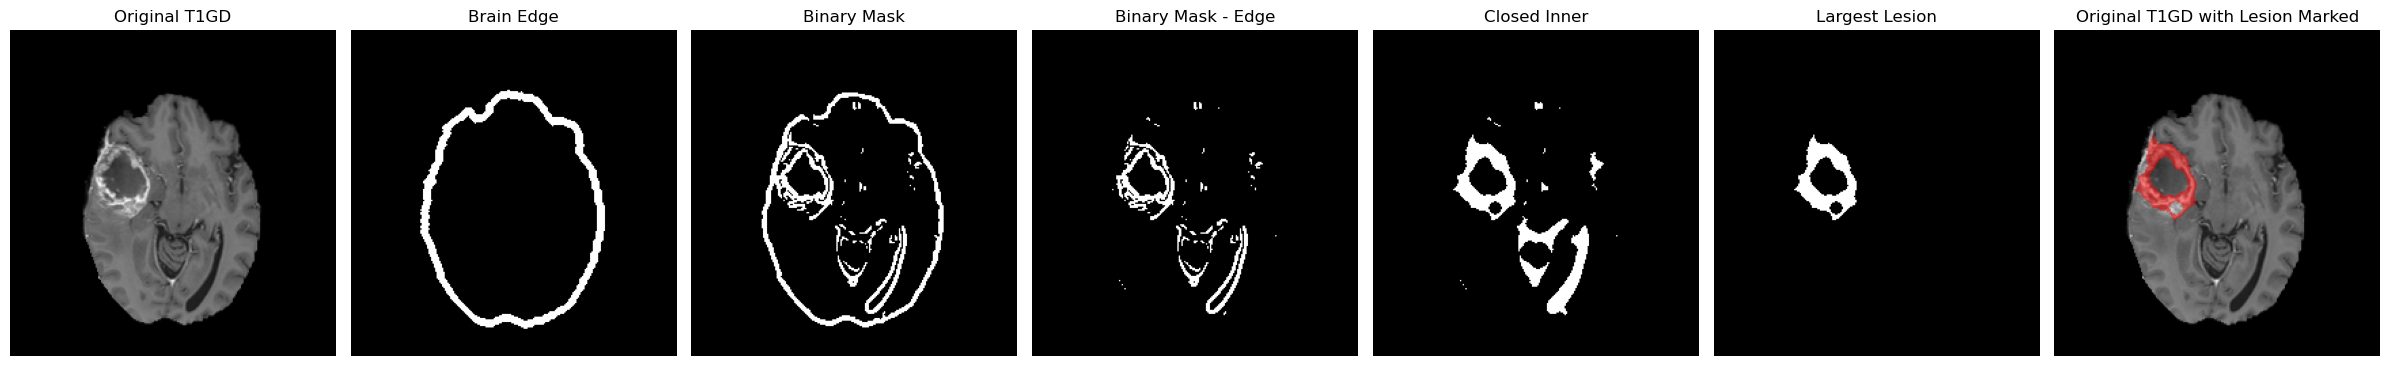

In [ ]:
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
import matplotlib.pyplot as plt

# 定义 5x5 高斯滤波函数
def apply_gaussian_smoothing(image, sigma=1.0):
    return ndimage.gaussian_filter(image, sigma=sigma)

    # 定义 Sobel 滤波函数
def apply_sobel_filter(image):
    sobel_x = ndimage.sobel(image, axis=0)
    sobel_y = ndimage.sobel(image, axis=1)
    return np.sqrt(sobel_x**2 + sobel_y**2)

# ------------------- 生成脑子掩码和边缘 -------------------
# 生成全白的脑子掩码的阈值
brain_mask_threshold = 0.05
full_white_brain_mask = (t1gd_data > brain_mask_threshold).astype(np.uint8)

# 定义结构元素用于腐蚀操作
erosion_structure_element = morphology.disk(2)
eroded_brain_mask = morphology.binary_erosion(full_white_brain_mask, erosion_structure_element)

# 计算大脑边缘
brain_edge = full_white_brain_mask - eroded_brain_mask
dilated_brain_edge = morphology.binary_dilation(brain_edge, erosion_structure_element)

# 应用高斯滤波
smoothed_t1_weighted_data = apply_gaussian_smoothing(t1gd_data)
# 应用 Sobel 滤波
sobel_gradient_image = apply_sobel_filter(smoothed_t1_weighted_data)

# ------------------- 生成二值掩码并处理 -------------------
# 生成二值掩码的阈值
binary_mask_threshold = 0.4
binary_mask = np.where(sobel_gradient_image > binary_mask_threshold, 1, 0).astype(np.uint8)

# 转换为有符号整数类型再进行相减
signed_binary_mask = binary_mask.astype(np.int8)
signed_brain_edge = dilated_brain_edge.astype(np.int8)
subtraction_result = signed_binary_mask - signed_brain_edge

# 确保结果为二值图像
binary_subtraction_result = np.clip(subtraction_result, 0, 1).astype(np.uint8)

# 对结果执行闭运算
closing_structure_element = morphology.disk(4)
closed_binary_result = morphology.binary_closing(binary_subtraction_result, closing_structure_element)

# 标记连通区域
labeled_connected_components = measure.label(closed_binary_result)
region_properties = measure.regionprops(labeled_connected_components)

# 找出面积最大的区域
max_region_area = 0
max_region_label = 0
for region in region_properties:
    if region.area > max_region_area:
        max_region_area = region.area
        max_region_label = region.label

# 仅保留面积最大的区域
largest_lesion_mask = (labeled_connected_components == max_region_label).astype(np.uint8)

# 在原始图像上标记出 lesion 的位置
# 创建一个带有颜色通道的图像副本
colored_t1_weighted_data = np.dstack([t1gd_data] * 3)

# 将 lesion 区域标记为红色（可调整颜色）
red_color = np.array([1, 0, 0])  # 红色
transparency = 0.5  # 透明度
colored_t1_weighted_data[largest_lesion_mask.astype(bool)] = (
    transparency * red_color + (1 - transparency) * colored_t1_weighted_data[largest_lesion_mask.astype(bool)]
)

# ------------------- 绘制图像 -------------------
# 绘制大图，调整子图数量为 7
fig, axes = plt.subplots(1, 7, figsize=(24, 5))

# 1. 原始图
axes[0].imshow(t1gd_data, cmap='gray')
axes[0].set_title('Original T1GD')
axes[0].axis('off')

# 2. 大脑边缘图
axes[1].imshow(dilated_brain_edge, cmap='gray')
axes[1].set_title('Brain Edge')
axes[1].axis('off')

# 3. 二值掩码图
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Binary Mask')
axes[2].axis('off')

# 4. binary mask 减去 edge 的结果图
axes[3].imshow(binary_subtraction_result, cmap='gray')
axes[3].set_title('Binary Mask - Edge')
axes[3].axis('off')

# 5. result 执行闭运算后的结果图
axes[4].imshow(closed_binary_result, cmap='gray')
axes[4].set_title('Closed Inner')
axes[4].axis('off')

# 6. 仅保留面积最大的 lesion 部分
axes[5].imshow(largest_lesion_mask, cmap='gray')
axes[5].set_title('Largest Lesion')
axes[5].axis('off')

# 7. 标记出 lesion 位置的原始图像
axes[6].imshow(colored_t1_weighted_data)
axes[6].set_title('Original T1GD with Lesion Marked')
axes[6].axis('off')

plt.tight_layout()
plt.show()

### T2W-Lesion Segmentation

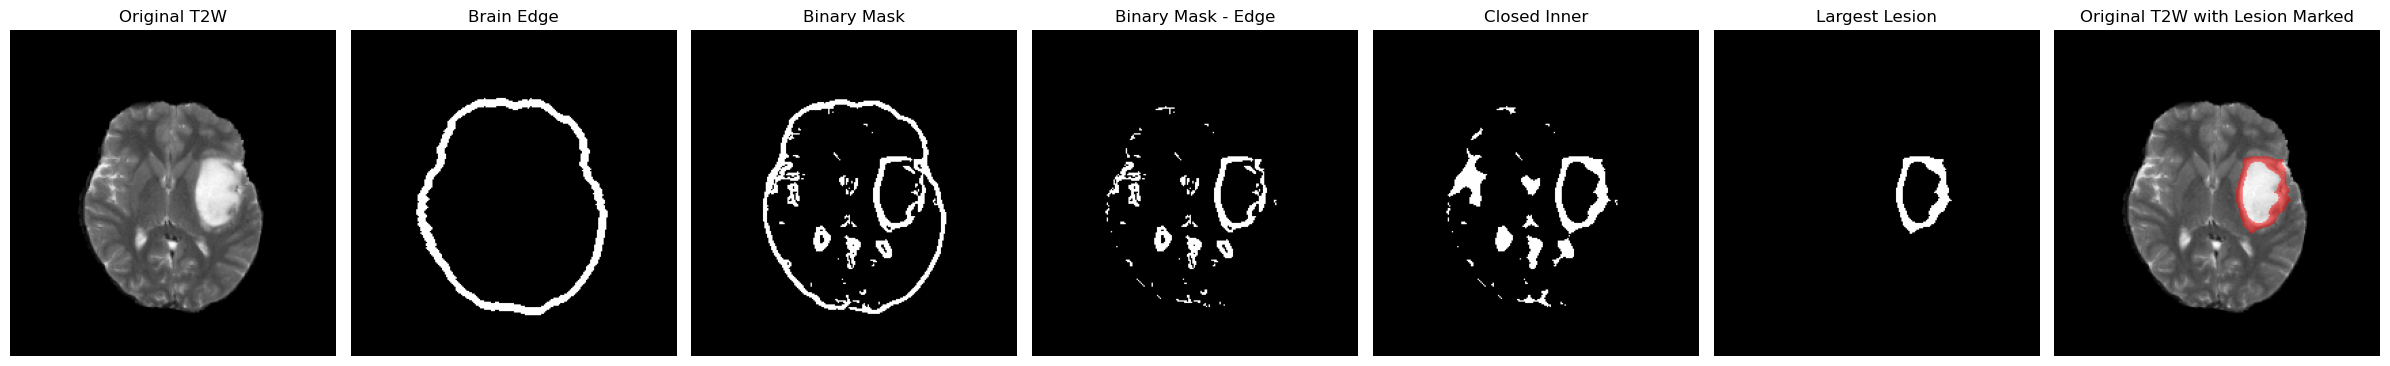

In [ ]:
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
import matplotlib.pyplot as plt

# 假设 t2w_data 已经被正确读取
# t2w_data = np.load('./data/lab5_t2w.npy')

# 定义 5x5 高斯滤波函数
def apply_gaussian_smoothing(image, sigma=1.0):
    return ndimage.gaussian_filter(image, sigma=sigma)

# 定义 Sobel 滤波函数
def apply_sobel_filter(image):
    sobel_x = ndimage.sobel(image, axis=0)
    sobel_y = ndimage.sobel(image, axis=1)
    return np.sqrt(sobel_x**2 + sobel_y**2)

# ------------------- 生成脑子掩码和边缘 -------------------
# 生成全白的脑子掩码的阈值
brain_mask_threshold = 0.05
full_white_brain_mask = (t2w_data > brain_mask_threshold).astype(np.uint8)

# 定义结构元素用于腐蚀操作
erosion_structure_element = morphology.disk(2)
eroded_brain_mask = morphology.binary_erosion(full_white_brain_mask, erosion_structure_element)

# 计算大脑边缘
brain_edge = full_white_brain_mask - eroded_brain_mask
dilated_brain_edge = morphology.binary_dilation(brain_edge, erosion_structure_element)

# 应用高斯滤波
smoothed_t2w_data = apply_gaussian_smoothing(t2w_data)
# 应用 Sobel 滤波
sobel_gradient_image = apply_sobel_filter(smoothed_t2w_data)

# ------------------- 生成二值掩码并处理 -------------------
# 生成二值掩码的阈值
binary_mask_threshold = 0.4
binary_mask = np.where(sobel_gradient_image > binary_mask_threshold, 1, 0).astype(np.uint8)

# 转换为有符号整数类型再进行相减
signed_binary_mask = binary_mask.astype(np.int8)
signed_brain_edge = dilated_brain_edge.astype(np.int8)
subtraction_result = signed_binary_mask - signed_brain_edge

# 确保结果为二值图像
binary_subtraction_result = np.clip(subtraction_result, 0, 1).astype(np.uint8)

# 对结果执行闭运算
closing_structure_element = morphology.disk(4)
closed_binary_result = morphology.binary_closing(binary_subtraction_result, closing_structure_element)

# 标记连通区域
labeled_connected_components = measure.label(closed_binary_result)
region_properties = measure.regionprops(labeled_connected_components)

# 找出面积最大的区域
max_region_area = 0
max_region_label = 0
for region in region_properties:
    if region.area > max_region_area:
        max_region_area = region.area
        max_region_label = region.label

# 仅保留面积最大的区域
largest_lesion_mask = (labeled_connected_components == max_region_label).astype(np.uint8)

# 在原始图像上标记出 lesion 的位置
# 创建一个带有颜色通道的图像副本
colored_t2w_data = np.dstack([t2w_data] * 3)

# 将 lesion 区域标记为红色（可调整颜色）
red_color = np.array([1, 0, 0])  # 红色
transparency = 0.5  # 透明度
colored_t2w_data[largest_lesion_mask.astype(bool)] = (
    transparency * red_color + (1 - transparency) * colored_t2w_data[largest_lesion_mask.astype(bool)]
)

# ------------------- 绘制图像 -------------------
# 绘制大图，调整子图数量为 7
fig, axes = plt.subplots(1, 7, figsize=(24, 5))

# 1. 原始图
axes[0].imshow(t2w_data, cmap='gray')
axes[0].set_title('Original T2W')
axes[0].axis('off')

# 2. 大脑边缘图
axes[1].imshow(dilated_brain_edge, cmap='gray')
axes[1].set_title('Brain Edge')
axes[1].axis('off')

# 3. 二值掩码图
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Binary Mask')
axes[2].axis('off')

# 4. binary mask 减去 edge 的结果图
axes[3].imshow(binary_subtraction_result, cmap='gray')
axes[3].set_title('Binary Mask - Edge')
axes[3].axis('off')

# 5. result 执行闭运算后的结果图
axes[4].imshow(closed_binary_result, cmap='gray')
axes[4].set_title('Closed Inner')
axes[4].axis('off')

# 6. 仅保留面积最大的 lesion 部分
axes[5].imshow(largest_lesion_mask, cmap='gray')
axes[5].set_title('Largest Lesion')
axes[5].axis('off')

# 7. 标记出 lesion 位置的原始图像
axes[6].imshow(colored_t2w_data)
axes[6].set_title('Original T2W with Lesion Marked')
axes[6].axis('off')

plt.tight_layout()
plt.show()

# Project 2 Thresholding

Implement Iterative global threshold segmentation
- Test different initial T values

Implement Otsu's optimum thresholding algorithm to segment the lesion (Not call the library)
- Test and compare the results on the brain

# Project 3 Segmentation


- Use the T2w data
- Call Region Growing, K-mean Cluster, and Watershed Segmentation functions
- Segment the lesion and calculate its volume
    - Suppose the image resolution is (x, y)=(1mm, 1mm)

